In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from pathlib import Path
import torch as th
import torch.nn.functional as F
from src.guidance.reconstruction import ReconstructionGuidance
from src.model.resnet import load_classifier
from src.utils.net import Device, get_device
from src.diffusion.base import DiffusionSampler
from src.diffusion.beta_schedules import improved_beta_schedule
from src.model.unet import load_mnist_diff
from src.utils.vis import every_nth_el, plot_reconstr_diff_seq, plot_accs, plot_samples_grid
from src.utils.classification import accuracy, logits_to_label

def _load_class(class_path: Path, device):
    classifier = load_classifier(class_path)
    classifier.to(device)
    classifier.eval()
    return classifier

def reconstr_accuracy(samples, classifier, guidance, ys):
    accs = []
    for t, x_t_batch in samples:
        x_t_batch = x_t_batch.to(th.device("cuda"))
        base_pred_ys = logits_to_label(classifier(x_t_batch))
        base_acc_t = accuracy(ys, base_pred_ys)
        x_0_hat = guidance.predict_x_0(x_t_batch, t)
        rec_pred_ys = logits_to_label(classifier(x_0_hat))
        rec_acc_t = accuracy(ys, rec_pred_ys)
        accs.append((t, base_acc_t, rec_acc_t))
    return accs

def _detach_samples():
    for (t, x_t) in samples:
        x_t.detach().cpu()

## Sample from unconditional diffusion model

In [3]:
device = get_device(Device.GPU)
models_dir = Path.cwd().parent / "models"
uncond_diff = load_mnist_diff(models_dir / "uncond_unet_mnist.pt", device)
T = 1000
diff_sampler = DiffusionSampler(improved_beta_schedule, num_diff_steps=T)
diff_sampler.to(device)
num_samples = 20
print("Sampling x_0:T")
diff_samples_0, diff_samples = diff_sampler.sample(uncond_diff, num_samples, device, th.Size((1, 28, 28)))


Sampling x_0:T


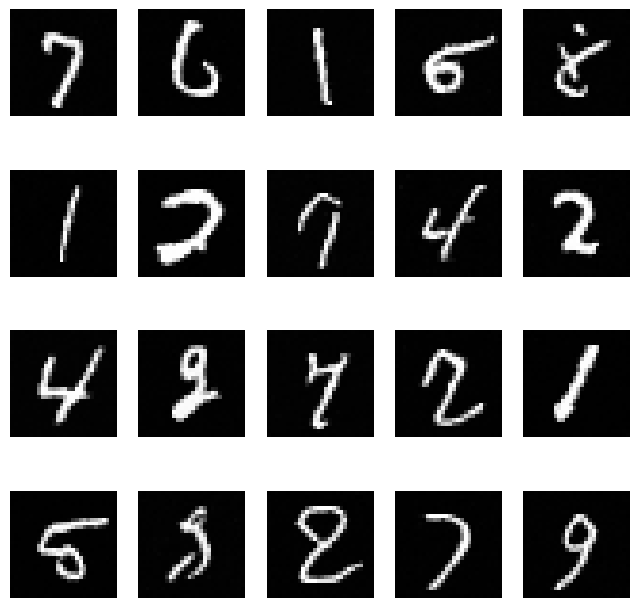

In [4]:
diff_samples_0 = diff_samples_0.detach().cpu()
plot_samples_grid(diff_samples_0, (4, 5))

## Classification

In [5]:
classifier = _load_class(models_dir / "resnet_reconstruction_classifier_mnist.pt", device)
guidance = ReconstructionGuidance(uncond_diff, classifier, diff_sampler.alphas_bar.clone(), F.cross_entropy)
pred_class = logits_to_label(classifier(diff_samples_0.clone().to(device)))
accs = reconstr_accuracy(diff_samples, classifier, guidance, pred_class)


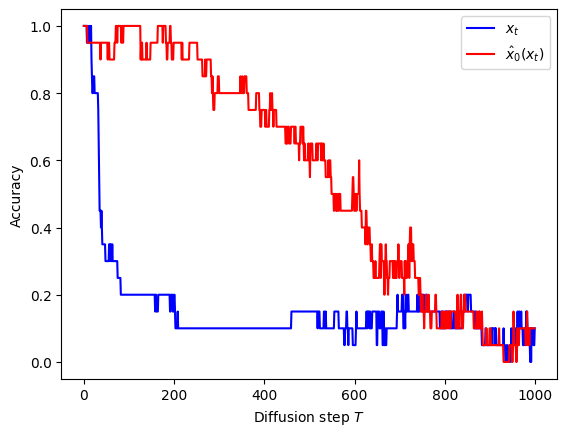

In [6]:
plot_accs(accs)

In [7]:
logits = classifier(diff_samples_0.clone().to(device))
from src.utils.classification import entropy
p = F.softmax(logits, dim=1)
entropy(p)

0.2181461900472641

# Reconstruction

In [102]:
from src.guidance.reconstruction import ReconstructionGuidance, ReconstructionSampler
from src.model.resnet import load_classifier
from src.utils.net import Device, get_device
from src.diffusion.base import DiffusionSampler
from src.diffusion.beta_schedules import improved_beta_schedule
from src.model.unet import load_mnist_diff
from src.utils.vis import plot_samples_grid



#args = parse_args()
guid_scale = 100.0
device = get_device(Device.GPU)
#models_dir = Path.cwd() / "models"
#uncond_diff = load_mnist_diff(models_dir / "uncond_unet_mnist.pt", device)
#classifier = _load_class(models_dir / "resnet_reconstruction_classifier_mnist.pt", device)
T = 1000
diff_sampler = DiffusionSampler(improved_beta_schedule, num_diff_steps=T)
diff_sampler.to(device)

guidance = ReconstructionGuidance(uncond_diff, classifier, diff_sampler.alphas_bar.clone(), lambda_= guid_scale)
reconstr_guided_sampler = ReconstructionSampler(uncond_diff, diff_sampler, guidance, verbose=True)

num_samples = 100
classes = th.ones((num_samples,), dtype=th.int64)
reconstr_samples, intermediate_samples = reconstr_guided_sampler.sample(num_samples, classes, device, th.Size((1, 28, 28)))


Diffusion step 1000
Diffusion step 900
Diffusion step 800
Diffusion step 700
Diffusion step 600
Diffusion step 500
Diffusion step 400
Diffusion step 300
Diffusion step 200
Diffusion step 100


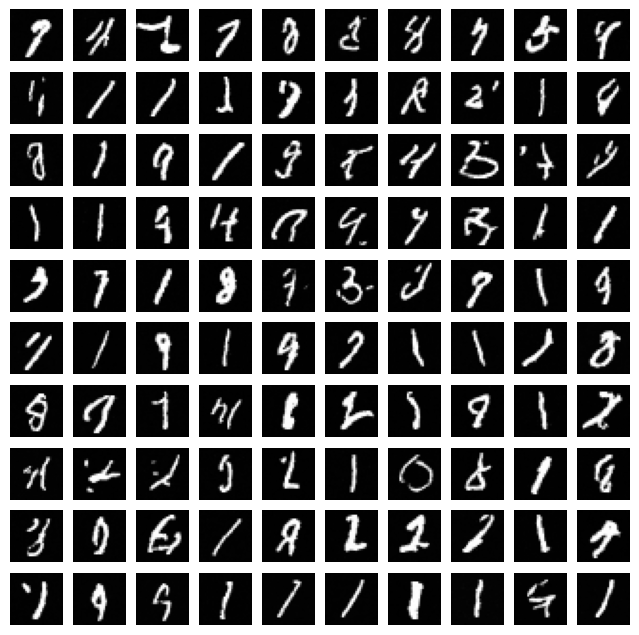

In [103]:
reconstr_samples = reconstr_samples.detach().cpu()
plot_samples_grid(reconstr_samples)

In [95]:
x = th.randn((1, 1, 28, 28)).to(device)
logits = classifier(x)
p = logits_to_prob_vec(logits)
p.log()

tensor([[-25.8147, -25.9856, -22.6983, -23.2984,  -0.3504, -31.9957, -21.6756,
         -24.5292,  -1.2189, -16.1842]], device='cuda:0',
       grad_fn=<LogBackward0>)

In [83]:
logits = th.Tensor([-2.0755e+03, -2.9268e+03, -1.2058e+03,  5.2328e+02, -2.1576e+03,
         -1.5691e+03,  3.5321e+02, -2.5280e+03,  3.2625e+03, -4.6073e+02]).reshape((1, logits.size(0)))
logits_to_prob_vec(logits)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])